<div style="font-size:25px"><b>DATASCI 207 Final Group Project</b></div><br>
<div style="font-size:20px"><b>Scene Classification using CNN_2D, CNN_1D, and Multi-Class Logistic Regression</b></div>
<div style="font-size:18px">Team: KT Norton, Yuri Kinakin, Judd Gallares</div><br>
<div style="font-size:17px">Prof. Nedelina Teneva</div>
<div style="font-size:16px">University of California, Berkeley</div>

#### Imports and Global Variables

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os
import csv
import time

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
rom keras import layers

# plots
import seaborn as sns
import matplotlib.pyplot as plt

# others
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display, HTML, display_html
from PIL import Image

In [2]:
# Added GPU configs
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.compat.v1.Session(config=config)

# File read
main_path = r"C:\Users\judd_gallares\W207\group_project"
train_path = os.path.join(main_path,r"train_scene_classification")

# img_path = "./train_scene_classification/train/"                   # get image file path
img_path = os.path.join(train_path,r"train")

# df_train = pd.read_csv("./train_scene_classification/train.csv")   # read train label csv
df_train = pd.read_csv(os.path.join(train_path,r"train.csv"))

# df_test = pd.read_csv("./test_WyRytb0.csv")                        # read test image name csv
df_test = pd.read_csv(os.path.join(main_path,r"test_WyRytb0.csv"))

# Assign names to label_ids: 0-5
# The labels have been rearranged from their order in kaggle to how they correspond to images in train.csv 
label_name = ['buildings','forests','glacier','mountains','sea','street']

class_count = len(label_name)           # class count: refer to Kaggle class descriptions
img_count = len(os.listdir(img_path))   # number of images in img_path
train_lbl_count = len(df_train)         # number of labels in train.csv 
test_lbl_count = len(df_test)

print("Check var_counts:")
print("  class_count:", class_count)
print("  img_count  :", img_count)
print("  train_lbl_count:", train_lbl_count)
print("  test_lbl_count :", test_lbl_count)


Check var_counts:
  class_count: 6
  img_count  : 24335
  train_lbl_count: 17034
  test_lbl_count : 7301


### A. Problem Motivation 

Image classification is an important research problem in computer vision and our task particularly is to identify outdoor scenes.  Though our data deal with only a few classes, we see this in a broader sense applied in **recommendation engines** like in photography travel blogs that suggest contents to users based on photos that they liked, interacted with, or posted. We can also see this enhance **image/video searches** or **metadata generation for digital assets** and so on.


### B.  Dataset Description

Source: https://www.kaggle.com/datasets/nitishabharathi/scene-classification?resource=download&select=train-scene+classification. <br> Original Source: https://creativecommons.org/publicdomain/zero/1.0/.


The data contains ~25k images from around the world of natural outdoor scenes, which are classified in one of 6 classes namely,

 1. &nbsp; Buildings
 2. &nbsp; Forests
 3. &nbsp; Mountains
 4. &nbsp; Glacier
 5. &nbsp; Street
 6. &nbsp; Sea

The dataset has a *'train'* image folder containing 24,335 of mostly 150x150px colored jpegs. This comes with two csvs, *train.csv* with 17,034 labels, and *test_WyRytb0.csv* with 7,301 unlabeled image names that correspond to jpegs in the *train* folder.  The final challenge thus is to predict and assign labels to the 7,301 test "images" and get a visual sampling of how accurate they are.

The images are typical in a lot of Instagram posts using today's high-tech mobile cameras.  For a visual sampling of the images/labels, see E2 below.

### C. Solution/ Approach Description

The goal is to build and train an ML model or models that can extract distinct features from the collection of outdoor scenes and use such learnings to predict the labels of yet unseen images. 

Our team decided on: **(1) Convolutional Neural Network (CNN) 2D - RGB, (2) CNN 1D - Grayscale, and (3) Multiclass Logistic Regression - Grayscale** to determine the best solution.  We further explored the use of *Embeddings, Principal Component Analysis (PCA)* and other techniques for our EDA, the details of which are in a separate link.

### D. Exploratory Data Analysis (EDA) and Embeddings

https://www.kinakin.ca/w207-final-project

### E. Data Preparation

#### E1. Choose the same size images

There are images that are not of shape 150x150 but as there are only 55 of them, we found it more practical to omit rather than apply padding to them.

In [3]:
# to omit non-(150x150x3) images, set to False
# to include them by applying padding, set to True
pad_img = False

img_sorted = [0] * class_count
img_sorted = [[] for i in range(class_count)]

img_tmp = []
lbl_tmp = []

non_conform_count = 0
conform_count = 0

for i in range(train_lbl_count): 
    j = df_train.label[i]
    
    img = load_img(os.path.join(img_path, df_train.image_name[i]))
    
    m = img_to_array(img)
    
    if m.shape != (150,150,3):
        non_conform_count += 1
        
        if pad_img:
            m = np.pad(m,[(0,150 - m.shape[0]),(0,0),(0,0)])
        else:
            continue
    
    conform_count += 1
    
    img_sorted[j].append(img)
    img_tmp.append(m)
    lbl_tmp.append(j)

print("No. of images of shape (150,150,3):",conform_count)
print("No. of images not of shape (150,150,3):",non_conform_count)
print(f"Compare images with labels to train_lbl_count var: {conform_count + non_conform_count} vs. {train_lbl_count}")

No. of images of shape (150,150,3): 16979
No. of images not of shape (150,150,3): 55
Compare images with labels to train_lbl_count var: 17034 vs. 17034


#### E2. Generate an equal number of images for each class

As we have omitted images, we made sure that all classes are equally represented by maximizing the same number of images per category.

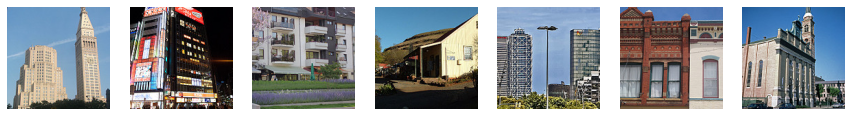

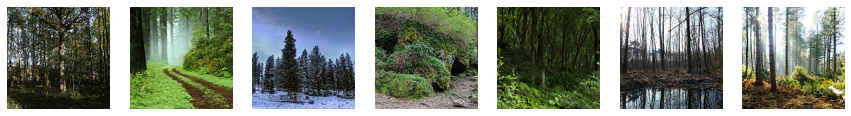

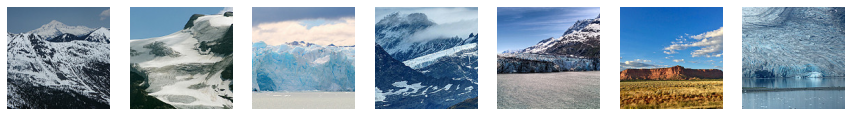

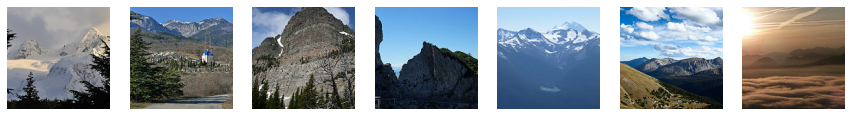

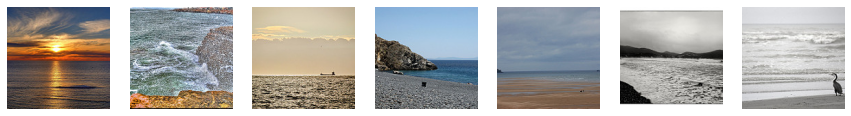

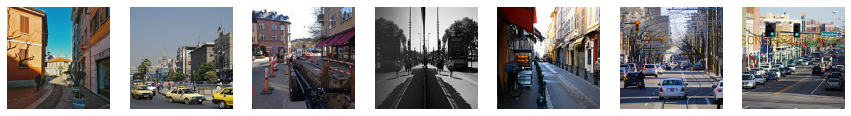

In [4]:
# max. equal number of images for each class to be included in the training, validation and testing sets
samp_count = 2627

# number of sample images to be previewed 
sub_samp = 7

samp = [0] * class_count
samp = [[] for i in range(class_count)]

img_arr = []
lbl_arr = []
gra_arr = []

def plot_sample_images(img,label=None,show_enum=False):
    """Accepts lists of images and labels 
       then plots them in grid format"""
    
    tmp = []
    
    fig = plt.figure(figsize=(15,30))
    gs = fig.add_gridspec(1,sub_samp)

    ax = [fig.add_subplot(gs[0,i]) for i in range(sub_samp)]
    
    for j in range(sub_samp):
        
        tmp.append('      ['+str(j+1)+']     ')
        
        ax[j].imshow(img[j])
        ax[j].axis('off')
        
        if label != None:
            if type(label) == list:
                ax[j].set_title(label_name[label[j]])
            else:
                ax[j].set_title(label)
        
    if show_enum:
        print(*tmp)
                
    plt.show()

random.seed(10)

display(HTML("<h3>Scene Image Sampling</h3>"))

for i in range(class_count):
    # gets random images from train
    r = random.sample(range(0, len(img_sorted[i])), samp_count)
    
    for j in range(samp_count):
        m = img_tmp[r[j]]
        
        # array of train images
        img_arr.append(m)
        
        # array of train labels
        lbl_arr.append(lbl_tmp[r[j]])
        
        # array of grayscale images
        gra_arr.append(tf.image.rgb_to_grayscale(m))

    for j in range(sub_samp):
        # images sorted according to labels
        m = img_sorted[i][r[j]]
        
        samp[i].append(m)
        
#    print(f'IDs of the samples per label: {r[:sub_samp]}\n{label_name[i].upper()}:')
    
    display(HTML("<h4><u>"+label_name[i].capitalize()+"</u></h4>"))
    plot_sample_images(samp[i],None,False)
    

#### E3. Check original and grayscale images 

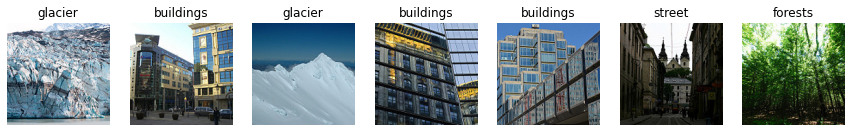

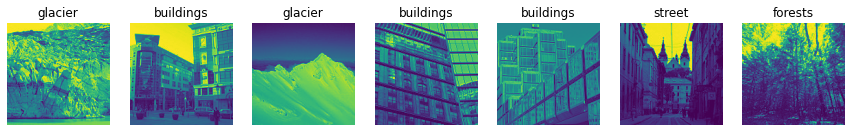

In [5]:
def show_sample_images(img,label=None,show_enum=True):
    t = []
    
    [t.append(array_to_img(img[i])) for i in range(sub_samp)]
    
    plot_sample_images(t,label,show_enum)

display(HTML("<h4>First "+str(sub_samp)+" images+labels from the original list:<h4>"))
show_sample_images(img_arr,list(lbl_arr[:sub_samp]),False)

display(HTML("<h4>The order above in grayscale:<h4>"))
show_sample_images(gra_arr,list(lbl_arr[:sub_samp]),False)


#### E4. Convert list of labels and images to numpy arrays

In [6]:
img_arr = np.array(img_arr)
gra_arr = np.array(gra_arr)
lbl_arr = np.array(lbl_arr)

# Validate: image and label shapes
print(f'original images  : shape: {img_arr.shape}, type: {type(img_arr)}')
print(f'grayscale images : shape: {gra_arr.shape}, type: {type(gra_arr)}')
print(f'image labels     : shape: {lbl_arr.shape}, type: {type(lbl_arr)}')

original images  : shape: (15762, 150, 150, 3), type: <class 'numpy.ndarray'>
grayscale images : shape: (15762, 150, 150, 1), type: <class 'numpy.ndarray'>
image labels     : shape: (15762,), type: <class 'numpy.ndarray'>


#### E5. Preprocessing method: Split data to training, validation, test and then shuffle them

The dataset *test_WyRytb0.csv* contain only strings of image names. However, to evaluate the accuracy versus the test data, labels are needed. Hence, we included 20% for testing (+ 60%--training; 20%--validation) in the data split below.

In [7]:
def split_transform_and_shuffle(images,labels,grays,split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets;
    
    Params:
    -------
    images (np.ndarray): Images of shape (N, 150, 150, 3)
    labels (np.ndarray): Labels of shape (N,)
    grays (np.ndarray): grayscale equivalent of param:images of shape (N, 150, 150) 
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 150, 150, 3)
    Xg_train (np.ndarray): Train images of shape (N_train, 150, 150, 1)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 150, 150, 3)
    Xg_val (np.ndarray): Train images of shape (N_train, 150, 150, 1)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 150, 150, 3)
    Xg_test (np.ndarray): Test images of shape (N_test, 150, 150, 1)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    # Create train/validation/test sets 
    tf.random.set_seed(3)
    np.random.seed(3)
    
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, labels, grays = images[shuffle], labels[shuffle], grays[shuffle]
    splits = np.multiply(len(images), split).astype(int)
        
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(labels, [splits[0], splits[0]+splits[1]])
    Xg_train, Xg_val, Xg_test = np.split(grays, [splits[0], splits[0]+splits[1]])
    
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    Xg_train = Xg_train/255.0
    Xg_val = Xg_val/255.0
    Xg_test = Xg_test/255.0
    
    # Shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    Xg_train = tf.gather(Xg_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() # also transforms y_train to numpy array
    
    return X_train, Xg_train, y_train, X_val, Xg_val, y_val, X_test, Xg_test, y_test    

#### E6. Data transformation: Apply preprocessing and outputs <i>train, val, and test</i> numpy array

In [8]:
X_train, Xg_train, y_train, X_val, Xg_val, y_val, X_test, Xg_test, y_test = split_transform_and_shuffle(
    images=img_arr,
    labels=lbl_arr,
    grays= gra_arr,
    split=(0.6,0.2,0.2))

X_train_2d = X_train
y_train_2d = y_train

print("Validate shape:")
print(f"  X_train shape {X_train.shape}")
print(f"  Xg_train shape {Xg_train.shape}")
print(f"  y_train shape {y_train.shape}")
print(f"  X_val shape {X_val.shape}")
print(f"  Xg_val shape {Xg_val.shape}")
print(f"  y_val shape {y_val.shape}")
print(f"  X_test shape {X_test.shape}")
print(f"  Xg_test shape {Xg_test.shape}")
print(f"  y_test shape {y_test.shape}")

print(f"\nTotal: {X_train.shape[0]+X_val.shape[0]+X_test.shape[0]} of {class_count*samp_count}")

Validate shape:
  X_train shape (9457, 150, 150, 3)
  Xg_train shape (9457, 150, 150, 1)
  y_train shape (9457,)
  X_val shape (3152, 150, 150, 3)
  Xg_val shape (3152, 150, 150, 1)
  y_val shape (3152,)
  X_test shape (3153, 150, 150, 3)
  Xg_test shape (3153, 150, 150, 1)
  y_test shape (3153,)

Total: 15762 of 15762


### F. Experiment_1: Convolutional Neural Network- 2D/RGB

#### F1. CNN_2D Model Build Method

In [9]:
def cnn2d_build(first_layer_filter_size=64,
                first_layer_kernel_size=(7,7),
                num_conv_layers=3):
    
    """Convolution Neural Network 2D with 
    
    Params:
    ------
    num_conv_layers (int): no. of convolution and dense layers
    first_layer_filter_size (int): no. of filters in the first Conv2D layer
    first_layer_kernel_size (tuple): the kernel size at the first layer
    
    Returns: compiled CNN_2D model
    
    """
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.Sequential()
    
    sf = first_layer_filter_size
    su = first_layer_filter_size
    
    # creates conv2d layers based on arg: num_conv_layers
    for i in range(num_conv_layers):
        ks = first_layer_kernel_size if i == 0 else (3, 3) 
        
        # convolution layer/s
        model.add(tf.keras.layers.Conv2D(
            filters=sf,
            kernel_size=ks,
            strides=(1, 1),
            padding='same',
            data_format='channels_last',
            name='conv_'+str(i + 1),
            activation='relu'))

        # max pooling layer/s with pool size (2,2), strides of 2
        model.add(tf.keras.layers.MaxPool2D(
            pool_size=(2, 2), 
            name='pool_'+str(i+1)))
        
        # reduce subsequent filter sizes by half
        sf = sf/2

    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    
    # add dense layers
    for i in range(num_conv_layers - 1):
        cnn_2d.add(tf.keras.layers.Dense(
            units=su,
            name='fc_'+str(i + 1), 
            activation='relu'))

        # add dropout layer
        cnn_2d.add(tf.keras.layers.Dropout(rate=0.5))
        
        # reduce subsequent number of dense layer units by half
        su = su/2

    nm = 'fc_1' if num_conv_layers == 1 else 'fc_'+str(i + 2)

    # output layer
    model.add(tf.keras.layers.Dense(
        units=class_count,
        name=nm,
        activation='softmax'))

    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=X_train.shape)
    model.summary()
    
    model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
    
    return model

#### F2. Hyperparameter Tuning: Run iterations to find optimum hyperparameters for CNN_2D

Based on research and initial tests, we found that certain hyperparameters are optimal for scene classification such as in the Conv2D/Dense layer **activation= 'relu'**, the final Dense layer **activation='softmax'**, and in the *cnn2d.compile()* settings **loss='SparseCategoricalCrossentropy'** and **optimizer= 'Adam'**.  Also, we fixed as default the **Conv2D strides=(1,1)**, **MaxPool2D pool_size=(2,2)** and **Dropout rate=0.5**.  As such, we narrowed down the variables as,

- **first_layer_filter_size:** &nbsp;&nbsp; [ cases: 64, 32, 16 ]
- **first_layer_kernel_size:** [ (5,5),(3,3),(1,1) ]
- **num_conv_layers:** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [ 1,2,3 ]

In [10]:
filter_size = []
kernel_size = []
n_layers = []
build_mins = []
hist_loss = []
hist_accu = []
hist_val_loss = []
hist_val_accu = []

# Hypertuning Method
def run_cnn2d_cases(epochs=5):
    """Loops through the given hyperparameter cases and returns
       model history of loss and accuracy values of each case
    """
    
    r = 3
    
    for i in range(r):
        for j in range(r):
            f = 64
            ks = (5 - (j * 2), 5 - (j * 2))
            
            for k in range(r):
                cnn2d_start = time.time()
                
                print(f"""\nLoop No: {i+1}_{j+1}_{k+1}; 
                            first_layer_ilter_size={f};
                            first_layer_kernel_size={ks};
                            num_conv_layers={i+1}\n""")

                filter_size.append(f)
                kernel_size.append(ks)
                n_layers.append(i+1)
                
                cnn_2d = cnn2d_build(
                    first_layer_filter_size=f,
                    first_layer_kernel_size=ks,
                    num_conv_layers=i+1)
                
                f = f/2

                history_2d = cnn_2d.fit(
                    X_train,
                    y_train,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    verbose=1)
                
                hist_loss.append(history_2d.history['loss'][-1])
                hist_accu.append(history_2d.history['accuracy'][-1])
                hist_val_loss.append(history_2d.history['val_loss'][-1])
                hist_val_accu.append(history_2d.history['val_accuracy'][-1])
                
                build_time = (time.time() - cnn2d_start)/60
                build_mins.append(build_time)
                
                print(f"\nBuild_time for loop_{i+1}_{j+1}_{k+1} in minutes: {build_time}")

# Uncomment to run Model Build Iterator
# run_cnn2d_cases()

#### F3. Select best CNN_2D hyperparameters from tuning results

Executing the hyperparameter tuning: *run_cnn2d_cases()* method takes a while. Thus, we wrote-to-csv a copy of the dataframe from the earlier run to avoid repeating this long process every refresh time. Set *is_write_to_csv=False* to read and display the csv. 

In [11]:
is_write_to_csv = False

df = pd.DataFrame()

if is_write_to_csv:
    df['train_loss'] = np.around(hist_loss, 4)
    df['train_accu'] = np.around(hist_accu, 4)
    df['val_loss'] = np.around(hist_val_loss, 4)
    df['val_accu'] = np.around(hist_val_accu, 4)
    df['filter1_size'] = filter_size
    df['kernel1_size'] = kernel_size
    df['num_conv_layers'] = n_layers
    df['build_minutes'] = build_mins
    
    df.to_csv('cnn2d_history_per_hp.csv',index=False)

else:
    df = pd.read_csv('cnn2d_history_per_hp.csv')

display(df)

,train_loss,train_accu,val_loss,val_accu,filter1_size,kernel1_size,num_conv_layers,build_minutes
0,0.0031,0.9999,0.0361,0.9905,64.0,"(5, 5)",1,8.879024
1,0.0058,0.9996,0.0347,0.9911,32.0,"(5, 5)",1,4.789623
2,0.0077,0.9997,0.0368,0.9895,16.0,"(5, 5)",1,3.473544
3,0.0033,0.9998,0.0263,0.9930,64.0,"(3, 3)",1,6.649201
4,0.0040,0.9998,0.0288,0.9924,32.0,"(3, 3)",1,4.994755
5,0.0081,0.9998,0.0299,0.9933,16.0,"(3, 3)",1,2.412871
6,0.0824,0.9823,0.1419,0.9705,64.0,"(1, 1)",1,6.837631
7,0.1238,0.9722,0.1747,0.9559,32.0,"(1, 1)",1,3.754270
8,0.1947,0.9533,0.2762,0.9194,16.0,"(1, 1)",1,2.064861
9,0.0596,0.9861,0.0870,0.9832,64.0,"(5, 5)",2,13.014805


#### F4. Rebuild CNN_2D model by applying the best case and evaluating over more epochs

The data above show that loss/accuracy favor a CNN with just a single Conv2D layer. Since **num_conv_layer=1** results are clustered close together (all yielding accuracy > 0.98 and loss < 0.1 on the training and validation), we picked as our optimum case the combination with the lowest *build_time*.

In [12]:
def get_cnn2d_model(f_size=16,k_size=(3,3),n_layers=1,epochs=10):
    """Computes the cnn_2d model using the tuned hyperparameters"""
    
    model_start = time.time()

    model = cnn2d_build(
                first_layer_filter_size=f_size,
                first_layer_kernel_size=k_size,
                num_conv_layers=n_layers
            )

    m = model.fit(
                X_train,
                y_train,
                epochs=epochs,
                validation_data=(X_val, y_val),
                verbose=1
            )
    
    print("\nCNN_2D build time in minutes: ", (time.time() - model_start)/60)

    return model, m.history

model_path = os.path.join(main_path,r"scene_class_models")

if os.path.isfile(model_path+"\cnn2d_model.h5") is False:
    model = get_cnn2d_model()
    model[0].save(model_path+"\cnn2d_model.h5")
    
    df = pd.DataFrame(model[1])
    df.to_csv(model_path+"\cnn2d_hist.csv", index=False)
        

In [13]:
model_cnn2d = models.load_model(model_path+"\cnn2d_model.h5")

print("Check model_cnn2d load:")
model_cnn2d.summary()

history = pd.read_csv(model_path+"\cnn2d_hist.csv")
display(HTML("<h4>CNN_2D History<h4>"))
display(history)

Check model_cnn2d load:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 pool_1 (MaxPooling2D)       (None, 75, 75, 16)        0         
                                                                 
 flatten (Flatten)           (None, 90000)             0         
                                                                 
 fc_1 (Dense)                (None, 6)                 540006    
                                                                 
Total params: 540,454
Trainable params: 540,454
Non-trainable params: 0
_________________________________________________________________


,loss,accuracy,val_loss,val_accuracy
0,0.866400,0.744105,0.292244,0.939086
1,0.152774,0.967537,0.117689,0.975254
2,0.042329,0.996193,0.054600,0.993655
3,0.018004,0.998731,0.035299,0.992386
4,0.008062,0.999789,0.029871,0.993338
5,0.005093,0.999683,0.033212,0.992703
6,0.003324,0.999894,0.027870,0.992386
7,0.002067,1.000000,0.025452,0.993655
8,0.001560,1.000000,0.027564,0.993338
9,0.001182,1.000000,0.028806,0.992703


#### F5. CNN_2D Loss and Accuracy Plot

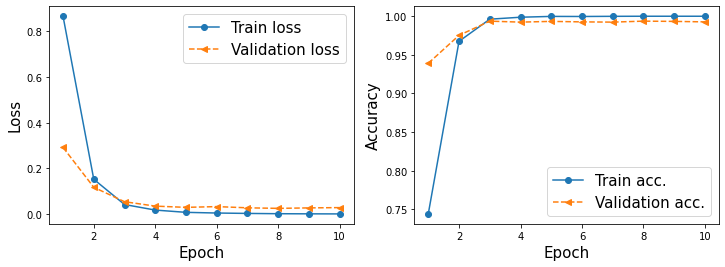

In [14]:
def plot_history(hist):
    """Plots model loss and accuracy per epoch"""
    
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

plot_history(history)

### G. Apply Experiment_1 CNN_2D Model to Test Data Run Predictions 

#### G1. Evaluate the CNN_2D Model vs. Test Data

In [15]:
model_cnn2d.evaluate(X_test,y_test)

99/99 [==============================] - 2s 18ms/step - loss: 0.0356 - accuracy: 0.9892


[0.03556890785694122, 0.9892166256904602]

#### G2. CNN_2D Model Predict

CNN_2D Predict:
99/99 [==============================] - 2s 19ms/step

The list below are from 7 adjacent images/labels starting from random id_no. 2125


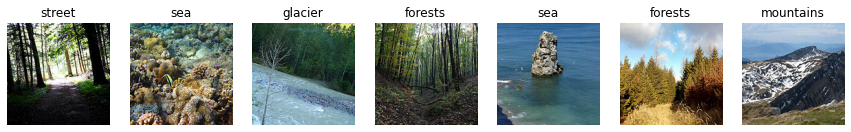

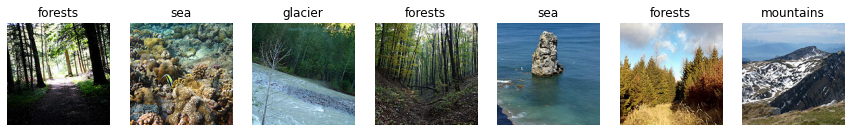

In [16]:
#tf.random.set_seed(4)

# Get a random starting point
r = random.randint(0, samp_count - sub_samp)

# Derive the predicted values of X_test
print("CNN_2D Predict:")
y = model_cnn2d.predict(X_test)
y_pred_cnn2d = [np.argmax(i) for i in y]

print(f"\nThe list below are from {sub_samp} adjacent images/labels starting from random id_no. {r}")
display(HTML("<h4>Actual test labels vs. test images:<h4>"))
plot_sample_images(X_test[r:r+sub_samp],list(y_pred_cnn2d[r:r+sub_samp]),False)

display(HTML("<h4>Predicted test labels vs. test images:<h4>"))
plot_sample_images(X_test[r:r+sub_samp],list(y_test[r:r+sub_samp]),False)

#### G3. Generate  Confusion Matrix and Classification Report

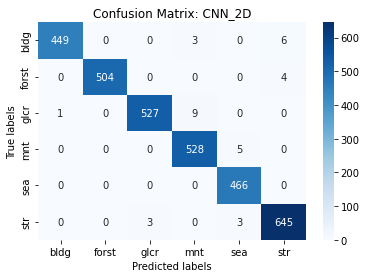

In [17]:
abbv_labels = ['bldg','forst','glcr','mnt','sea','str']

cm = confusion_matrix(y_test, y_pred_cnn2d,labels=None)

ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: CNN_2D'); 
ax.xaxis.set_ticklabels(abbv_labels); 
ax.yaxis.set_ticklabels(abbv_labels);

pass

In [18]:
c_r = classification_report(y_test,y_pred_cnn2d,output_dict=True)

df = pd.DataFrame(c_r).transpose()
df = df.round(4)

display(df)

,precision,recall,f1-score,support
0,0.9978,0.9803,0.9890,458.0000
1,1.0000,0.9921,0.9960,508.0000
2,0.9943,0.9814,0.9878,537.0000
3,0.9778,0.9906,0.9842,533.0000
4,0.9831,1.0000,0.9915,466.0000
5,0.9847,0.9908,0.9877,651.0000
accuracy,0.9892,0.9892,0.9892,0.9892
macro avg,0.9896,0.9892,0.9894,3153.0000
weighted avg,0.9893,0.9892,0.9892,3153.0000


<b><u>Classification Report Labels:</u></b>

&nbsp;&nbsp;&nbsp;&nbsp;<b>Precision :</b> Percentage of correct positive predictions relative to total positive predictions.<br>
&nbsp;&nbsp;&nbsp;&nbsp;<b>Recall &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;:</b> Percentage of correct positive predictions relative to total actual positives.<br>
&nbsp;&nbsp;&nbsp;&nbsp;<b>F1-Score &nbsp;:</b> A weighted harmonic mean of precision and recall. <b><u>The closer to 1, the better the model.</u></b>
<blockquote><b><i>F1-Score: 2 * (Precision * Recall) / (Precision + Recall)</i></b></blockquote>

&nbsp;&nbsp;&nbsp;&nbsp;<b>Support:</b> These values tell us how many images belong to each class in the test dataset. 

### H. Experiment_2: Convolutional Neural Network- 1D/Grayscale

#### H1. CNN_1D Model Build Method

In [19]:
# this is built based on learnings from cnn_2d, i.e. that the ideal 
# number of layers is just one and. thus, there are no layer loops here

def cnn1d_build(filters=64,kernel_size=3):
    """Convolution Neural Network 1D;
       Returns: compiled CNN_1D model
    """

    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        strides=1,
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu'))

    model.add(tf.keras.layers.MaxPool1D(
        pool_size=2,
        name='pool_1'))

    model.add(tf.keras.layers.Flatten()) 
    
    model.add(tf.keras.layers.Dense(
        units=class_count,
        name='fc_1',
        activation='softmax'))

    tf.random.set_seed(2)
    model.build(input_shape=(None,150,150))
    model.summary()
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])

    return model 

#### H2. Hyperparameter Tuning: Run iteration to find optimum hyperparameters for CNN_1D

In [20]:
filter_size = []
kernel_size = []
build_mins = []
hist_loss = []
hist_accu = []
hist_val_loss = []
hist_val_accu = []

# Hypertuning method
def run_cnn1d_cases(epochs=5):
    """Loops through the given hyperparameter cases and returns
       model history of loss and accuracy values of each case
    """

    r = 4
    
    for j in range(r):
        f = 512
        ks = 7 - (j * 2)

        for k in range(r):
            cnn1d_start = time.time()
            
            print(f"""\nLoop No: {j + 1}_{k + 1}; 
                    filters={f};
                    kernel_size={ks}\n""")

            filter_size.append(f)
            kernel_size.append(ks)

            cnn_1d = cnn1d_build(filters=f,kernel_size=ks)

            f = f/2

            history_1d = cnn_1d.fit(
                Xg_train,
                y_train,
                epochs=epochs,
                validation_data=(Xg_val, y_val),
                verbose=1)

            hist_loss.append(history_1d.history['loss'][-1])
            hist_accu.append(history_1d.history['accuracy'][-1])
            hist_val_loss.append(history_1d.history['val_loss'][-1])
            hist_val_accu.append(history_1d.history['val_accuracy'][-1])

            build_time = (time.time() - cnn1d_start)/60
            build_mins.append(build_time)
            print(f"\nBuild_time for loop_{j+1}_{k+1} in minutes: {build_time}")

# Uncomment to run Model Build Iterator
# run_cnn1d_cases()

#### H3. Select best CNN_1D hyperparameters from tuning results 

In [21]:
is_write_to_csv = False

df = pd.DataFrame()

if is_write_to_csv:
    df['train_loss'] = np.around(hist_loss, 4)
    df['train_accu'] = np.around(hist_accu, 4)
    df['val_loss'] = np.around(hist_val_loss, 4)
    df['val_accu'] = np.around(hist_val_accu, 4)
    df['filter1_size'] = filter_size
    df['kernel1_size'] = kernel_size
    df['build_minutes'] = build_mins
    
    df.to_csv('cnn1d_history_per_hp.csv',index=False)
else:
    df = pd.read_csv('cnn1d_history_per_hp.csv')
    
display(df)

,train_loss,train_accu,val_loss,val_accu,filter1_size,kernel1_size,build_minutes
0,1.0878,0.6101,1.0513,0.6164,512.0,7,1.086736
1,1.0349,0.6254,0.9917,0.6304,256.0,7,0.785027
2,1.1566,0.5726,1.1152,0.6028,128.0,7,0.524590
3,1.0901,0.5986,1.0910,0.5945,64.0,7,0.366595
4,0.8884,0.6853,0.8484,0.7151,512.0,5,1.088181
5,0.9727,0.6489,0.8982,0.6957,256.0,5,0.761362
6,0.9856,0.6459,0.9788,0.6475,128.0,5,0.455267
7,0.9464,0.6582,0.8821,0.6815,64.0,5,0.313599
8,0.5416,0.8218,0.5806,0.8068,512.0,3,0.828824
9,0.5583,0.8142,0.5468,0.8347,256.0,3,0.496039


#### H4. Rebuild CNN_1D model by applying the best case and evaluating over more epochs

The best case above happens to be index# 13, **filters=256, kernel_size=1**. 

In [22]:
def get_cnn1d_model(filt=256,k_size=1,epochs=15):
    """Computes the cnn_1d model using the tuned hyperparameters"""
    
    model_start = time.time()

    model = cnn1d_build(filters=filt, kernel_size=k_size)

    m = model.fit(
            Xg_train, 
            y_train,
            epochs=epochs, 
            validation_data=(Xg_val, y_val),
            verbose=1)

    print("\nCNN_1D build time in minutes: ", (time.time() - model_start)/60)
    
    return model, m.history

if os.path.isfile(model_path+"\cnn1d_model.h5") is False:
    model = get_cnn1d_model()
    model[0].save(model_path+"\cnn1d_model.h5")
    
    df = pd.DataFrame(model[1])
    df.to_csv(model_path+"\cnn1d_hist.csv", index=False)

In [23]:
model_cnn1d = models.load_model(model_path+"\cnn1d_model.h5")

print("Check model_cnn1d load:")
model_cnn1d.summary()

history = pd.read_csv(model_path+"\cnn1d_hist.csv")
display(HTML("<h4>CNN_1D History<h4>"))
display(history)

Check model_cnn1d load:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv1D)             (None, 150, 256)          38656     
                                                                 
 pool_1 (MaxPooling1D)       (None, 75, 256)           0         
                                                                 
 flatten (Flatten)           (None, 19200)             0         
                                                                 
 fc_1 (Dense)                (None, 6)                 115206    
                                                                 
Total params: 153,862
Trainable params: 153,862
Non-trainable params: 0
_________________________________________________________________


,loss,accuracy,val_loss,val_accuracy
0,1.189192,0.546791,0.888876,0.685596
1,0.699524,0.767685,0.628770,0.802348
2,0.426931,0.878503,0.480725,0.842957
3,0.259817,0.939516,0.262416,0.938769
4,0.159511,0.971238,0.188955,0.962563
5,0.114062,0.980015,0.135424,0.976840
6,0.065054,0.992704,0.096758,0.985089
7,0.042953,0.996616,0.099908,0.982551
8,0.031719,0.997674,0.074131,0.986675
9,0.019681,0.998202,0.086057,0.986041


#### H5. CNN_1D Loss and Accuracy Plot

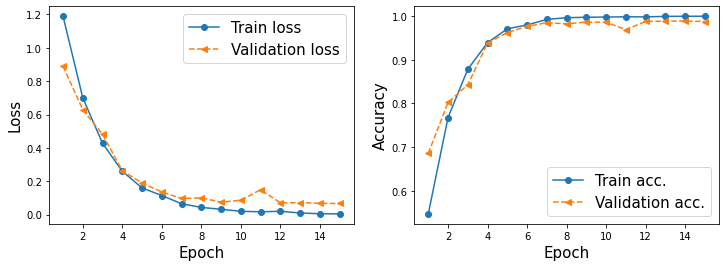

In [24]:
plot_history(history)

### I. Apply Experiment_2 CNN_1D Model to Test Data Run Predictions 

#### I1. Evaluate the CNN_1D Model vs. Test Data

In [25]:
model_cnn1d.evaluate(Xg_test,y_test)

99/99 [==============================] - 0s 4ms/step - loss: 0.0663 - accuracy: 0.9864


[0.06633953750133514, 0.9863622188568115]

#### I2. CNN_1D Model Predict

CNN_1D Predict:
99/99 [==============================] - 0s 4ms/step

The list below are from 7 adjacent images/labels starting from random id_no. 2314

Actual test labels vs. test images


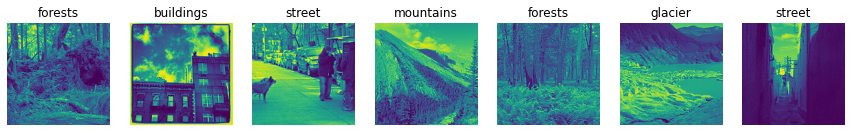

Predicted test labels vs. test images


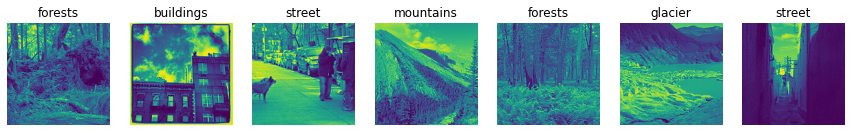

In [26]:
#tf.random.set_seed(4)

# Get a random starting point
r = random.randint(0, samp_count - sub_samp)

# Derive the predicted values of X_test
print("CNN_1D Predict:")
y = model_cnn1d.predict(Xg_test)
y_pred_cnn1d = [np.argmax(i) for i in y]

print(f"\nThe list below are from {sub_samp} adjacent images/labels starting from random id_no. {r}")
print("\nActual test labels vs. test images")
plot_sample_images(Xg_test[r:r+sub_samp],list(y_pred_cnn1d[r:r+sub_samp]),False)

print("Predicted test labels vs. test images")
plot_sample_images(Xg_test[r:r+sub_samp],list(y_test[r:r+sub_samp]),False)

#### I3. Generate Classification Report and Confusion Matrix

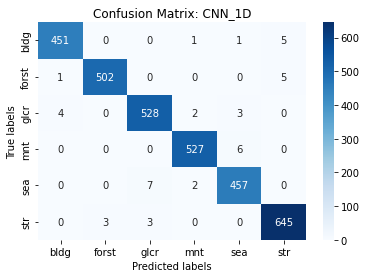

In [27]:
cm = confusion_matrix(y_test, y_pred_cnn1d,labels=None)

ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: CNN_1D'); 
ax.xaxis.set_ticklabels(abbv_labels); 
ax.yaxis.set_ticklabels(abbv_labels);

pass

In [28]:
c_r = classification_report(y_test,y_pred_cnn1d,output_dict=True)

df = pd.DataFrame(c_r).transpose()
df = df.round(4)

display(df)

,precision,recall,f1-score,support
0,0.9890,0.9847,0.9869,458.0000
1,0.9941,0.9882,0.9911,508.0000
2,0.9814,0.9832,0.9823,537.0000
3,0.9906,0.9887,0.9897,533.0000
4,0.9786,0.9807,0.9796,466.0000
5,0.9847,0.9908,0.9877,651.0000
accuracy,0.9864,0.9864,0.9864,0.9864
macro avg,0.9864,0.9861,0.9862,3153.0000
weighted avg,0.9864,0.9864,0.9864,3153.0000


### J. Experiment_3: Multiclass Logistical Regression (MCLR) - Grayscale

#### J1. MCLR Model Build Method

In [29]:
def mclr_build(learning_rate,optimizer):
    """Multi-class Logistic Regression of given learning_rate and optimizer;
       Returns the compiled model
    """
    
    tf.keras.backend.clear_session()
    np.random.seed(15)
    tf.random.set_seed(15)

    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(
        tf.keras.layers.Dense(
        units=class_count,
        activation='softmax'))
    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer(learning_rate=learning_rate), 
        metrics=['accuracy'])
    
    return model

#### J2. Hyperparameter Tuning: Run iteration to find optimum hyperparameters for MCLR

Use and combine the same X, y- train/val data as in CNN_1D

In [30]:
batch = []
optim = []
learn = []
build_mins = []
hist_loss = []
hist_accu = []
hist_val_loss = []
hist_val_accu = []

def run_mclr_cases(learning_rate=.001,
                   optimizer=tf.keras.optimizers.Adam,
                   batch_size=32,
                   epochs=10):

    mclr_start = time.time()
    
    op = 'SGD' if optimizer == tf.keras.optimizers.SGD else 'Adam'
    
    optim.append(op)
    learn.append(learning_rate)
    batch.append(batch_size)
    
    mclr = mclr_build(learning_rate,optimizer)

    history_mclr = mclr.fit(
            x = Xg_train,
            y = y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(Xg_val, y_val),
            verbose=1)
    
    hist_loss.append(history_mclr.history['loss'][-1])
    hist_accu.append(history_mclr.history['accuracy'][-1])
    hist_val_loss.append(history_mclr.history['val_loss'][-1])
    hist_val_accu.append(history_mclr.history['val_accuracy'][-1])

    build_time = (time.time() - mclr_start)/60
    build_mins.append(build_time)

def iterate_mclr(epochs=5):
    for i in range(2):
        le = [.01,.001]

        for j in range(2):
            op = [tf.keras.optimizers.SGD,tf.keras.optimizers.Adam]

            for k in range(4):
                ba = [16,32,64,128]

                run_mclr_cases(learning_rate=le[i],
                               optimizer=op[j],
                               batch_size=ba[k],
                               epochs=epochs)

# Uncomment to run
# iterate_mclr(epochs=5)

#### J3. Select best MCLR hyperparameters from tuning results

In [31]:
is_write_to_csv = False

df = pd.DataFrame()

if is_write_to_csv:
    df['train_loss'] = np.around(hist_loss, 4)
    df['train_accu'] = np.around(hist_accu, 4)
    df['val_loss'] = np.around(hist_val_loss, 4)
    df['val_accu'] = np.around(hist_val_accu, 4)
    df['learning_rate'] = learn
    df['optimizer'] = optim
    df['batch_size'] = batch
    df['build_minutes'] = build_mins

    df.to_csv('mclr_history_per_hp.csv',index=False)

else:
    df = pd.read_csv('mclr_history_per_hp.csv')

display(df)

,train_loss,train_accu,val_loss,val_accu,learning_rate,optimizer,batch_size,build_minutes
0,6.7473,0.4137,9.9451,0.2994,0.010,SGD,16,0.109472
1,7.4458,0.3583,10.9803,0.3013,0.010,SGD,32,0.084112
2,8.1361,0.3079,9.0917,0.1911,0.010,SGD,64,0.072873
3,8.7755,0.2798,6.4873,0.3291,0.010,SGD,128,0.050696
4,7.7553,0.6376,7.8813,0.5484,0.010,Adam,16,0.127180
5,6.6633,0.5805,4.9200,0.5940,0.010,Adam,32,0.104486
6,6.8394,0.4780,8.0615,0.4298,0.010,Adam,64,0.078916
7,7.7042,0.4089,8.9562,0.3624,0.010,Adam,128,0.064638
8,1.3522,0.4955,1.3371,0.5408,0.001,SGD,16,0.200528
9,1.4437,0.4470,1.4565,0.4742,0.001,SGD,32,0.115762


#### J4. Rebuild MCLR model by applying the best case and evaluating over more epochs

In [32]:
def get_mclr_model(learning_rate=0.001,
                    batch_size=32,
                    optimizer=tf.keras.optimizers.Adam,
                    epochs=50):
    
    """Computes the MCLR model using the tuned hyperparameters"""
    
    model_start = time.time()

    model = mclr_build(learning_rate,optimizer)

    m = model.fit(
            x = Xg_train,
            y = y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(Xg_val, y_val),
            verbose=1)

    print("\nMCLR build time in minutes: ", (time.time() - model_start)/60)
    
    return model, m.history

if os.path.isfile(model_path+"\mclr_model.h5") is False:
    model = get_mclr_model()
    model[0].save(model_path+"\mclr_model.h5")
    
    df = pd.DataFrame(model[1])
    df.to_csv(model_path+"\mclr_hist.csv", index=False)

In [33]:
model_mclr = models.load_model(model_path+"\mclr_model.h5")

print("Check model_mclr load:")
model_mclr.summary()

history = pd.read_csv(model_path+"\mclr_hist.csv")
display(HTML("<h4>MCLR History<h4>"))
display(history)

Check model_mclr load:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 22500)             0         
                                                                 
 dense (Dense)               (None, 6)                 135006    
                                                                 
Total params: 135,006
Trainable params: 135,006
Non-trainable params: 0
_________________________________________________________________


,loss,accuracy,val_loss,val_accuracy
0,2.321057,0.326319,2.214630,0.348985
1,1.672324,0.434387,1.581540,0.468274
2,1.367396,0.534842,1.484961,0.494607
3,1.180820,0.609073,0.907844,0.701777
4,1.017916,0.661521,1.179285,0.582487
5,0.829915,0.733002,1.109475,0.605647
6,0.652052,0.797716,1.166386,0.588832
7,0.672531,0.789785,1.309011,0.697970
8,0.529864,0.836312,0.701836,0.763642
9,0.525642,0.831765,0.607711,0.815673


#### J5. MCLR Loss and Accuracy Plot

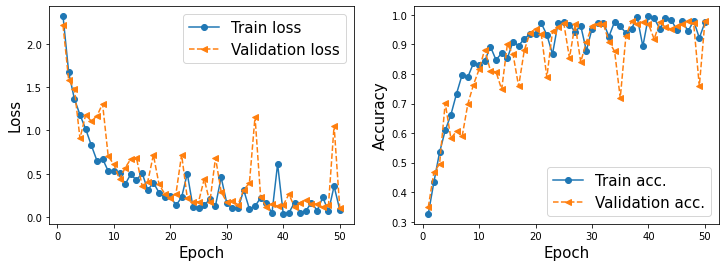

In [34]:
plot_history(history)

### K. Apply Experiment_3 MCLR Model to Test Data Run Predictions 

#### K1. Evaluate the CNN_1D Model vs. Test Data

In [35]:
model_mclr.evaluate(Xg_test,y_test)

99/99 [==============================] - 0s 969us/step - loss: 0.1503 - accuracy: 0.9800


[0.15025028586387634, 0.9800190329551697]

#### K2. MCLR Model Predict

CNN_1D Predict:
99/99 [==============================] - 0s 929us/step

The list below are from 7 adjacent images/labels starting from random id_no. 565

Actual test labels vs. test images


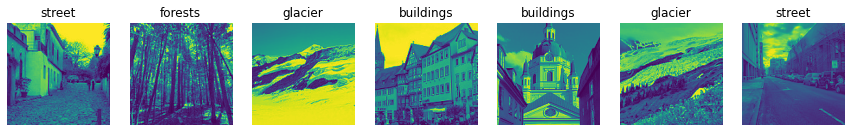

Predicted test labels vs. test images


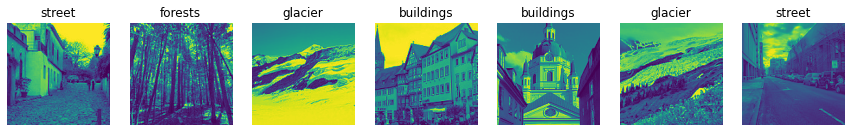

In [36]:
#tf.random.set_seed(4)

# Get a random starting point
r = random.randint(0, samp_count - sub_samp)

# Derive the predicted values of X_test

print("CNN_1D Predict:")

y = model_mclr.predict(Xg_test)
y_pred_mclr = [np.argmax(i) for i in y]

print(f"\nThe list below are from {sub_samp} adjacent images/labels starting from random id_no. {r}")
print("\nActual test labels vs. test images")
plot_sample_images(Xg_test[r:r+sub_samp],list(y_pred_mclr[r:r+sub_samp]),False)

print("Predicted test labels vs. test images")
plot_sample_images(Xg_test[r:r+sub_samp],list(y_test[r:r+sub_samp]),False)


#### K3. Generate Classification Report and Confusion Matrix

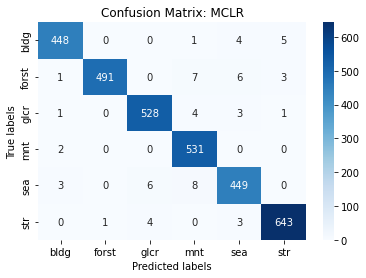

In [37]:
cm = confusion_matrix(y_test, y_pred_mclr,labels=None)

ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: MCLR'); 
ax.xaxis.set_ticklabels(abbv_labels); 
ax.yaxis.set_ticklabels(abbv_labels);

pass

In [38]:
c_r = classification_report(y_test,y_pred_mclr,output_dict=True)

df = pd.DataFrame(c_r).transpose()
df = df.round(4)

display(df)

,precision,recall,f1-score,support
0,0.9846,0.9782,0.9814,458.00
1,0.9980,0.9665,0.9820,508.00
2,0.9814,0.9832,0.9823,537.00
3,0.9637,0.9962,0.9797,533.00
4,0.9656,0.9635,0.9646,466.00
5,0.9862,0.9877,0.9870,651.00
accuracy,0.9800,0.9800,0.9800,0.98
macro avg,0.9799,0.9792,0.9795,3153.00
weighted avg,0.9802,0.9800,0.9800,3153.00


### L. Run Chosen Model vs. List of <i>test_WyRytb0.csv</i> Images; Save Images to File and Labels to csv

In [58]:
test_images_path = os.path.join(main_path,r"test_images")
cnn2d_pred_labels = main_path+"\predicted_test_labels_cnn2d.csv"

print(cnn2d_pred_labels)
print(test_images_path)

def get_and_save_image_data(start=0,end=len(df_test),save_img_to_file=False):
    m_arr = []
    j = 0
    
    for i in range(start,end):
        f = os.path.join(img_path, df_test.iloc[i][0])
        
        img = load_img(f)
        m = img_to_array(img)
        
        # skip images not of shape 150x150x3
        if m.shape != (150,150,3):
            continue
        
        if save_img_to_file:
            m = Image.open(f)
            m.save(os.path.join(test_images_path,r"test_"+str(j)+".jpg"))
            
            j += 1
        
        m_arr.append(m)
        
    return np.array(m_arr)

# def write_labels_to_csv(pred,file_name):
#     with open(file_name, 'w', newline='') as f:
#         for label in pred:
#             f.write(label)
#             f.write('\n')

#         print("Write-to-csv complete")

C:\Users\judd_gallares\W207\group_project\predicted_test_labels_cnn2d.csv
C:\Users\judd_gallares\W207\group_project\test_images


In [59]:
if os.path.isfile(test_images_path) is False: 
    test_img_arr = get_and_save_image_data(0,len(df_test),False)

if os.path.isfile(cnn2d_pred_labels) is False:
    y = model_cnn2d.predict(test_img_arr)
    y_pred = [np.argmax(i) for i in y]

    pred_test_label_cnn2d = [label_name[idx] for idx in y_pred]
    pred_test_label_cnn2d = pd.DataFrame(pred_test_label_cnn2d)

    pred_test_label_cnn2d.to_csv(cnn2d_pred_labels,index=False)
    pred_labels_len_cnn2d = len(pred_test_label_cnn2d)
    print("Write-to_csv complete")
#     write_labels_to_csv(pred_test_label_cnn2d, cnn2d_pred_labels)
    
else:
    df_cnn2d = pd.read_csv(cnn2d_pred_labels)
    pred_labels_len_cnn2d = len(df_cnn2d)

# compare test image to label counts
img_count = len(os.listdir(test_images_path))

print("\ntest_image_folder image count: ",img_count)
print("test_label_csv_cnn2d row count: ",pred_labels_len_cnn2d)
                           

228/228 [==============================] - 4s 18ms/step
Write-to_csv complete

test_image_folder image count:  7288
test_label_csv_cnn2d row count:  7288
